# Computing the energy of water on IBM

## Set experiment parameters

In [1]:
ibm_computer: str = "ibm_kingston"
qubits = [24, 25, 26, 27, 28, 29, 30, 37, 38, 45, 46, 47, 48, 49]
nshots: int = 10_000  # "Base" number of shots. See how shots are set per circuit/group below.

nqubits = len(qubits)
nqubits

14

## Setup

In [2]:
from collections import Counter
from typing import Tuple

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import numpy as np
import pickle

import cirq
from cirq.contrib.qasm_import import circuit_from_qasm
import openfermion as of

import qiskit
from qiskit import qasm2, qasm3
from qiskit_aer import AerSimulator
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [3]:
service = qiskit_ibm_runtime.QiskitRuntimeService(name="NERSC-US")
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

## Read in the Hamiltonian and ansatz circuit

In [4]:
hamiltonian_data = np.load("./hamiltonians/14q-jan13/h2o-integrals.npz")
mode_order = pickle.load(open("./hamiltonians/14q-jan13/h2o_circs_mode_order_681_2q.pkl", "rb"))

In [5]:
circuit_fname = "h2o_circs_circuit_681_2q.qasm"
circuit = qasm3.load(f"./circuits/14q-jan13/{circuit_fname}")
qubit_order = pickle.load(open("./circuits/14q-jan13/h2o_circs_qubit_order_681_2q.pkl", "rb"))

/tmp/ipykernel_2584/967061526.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend();


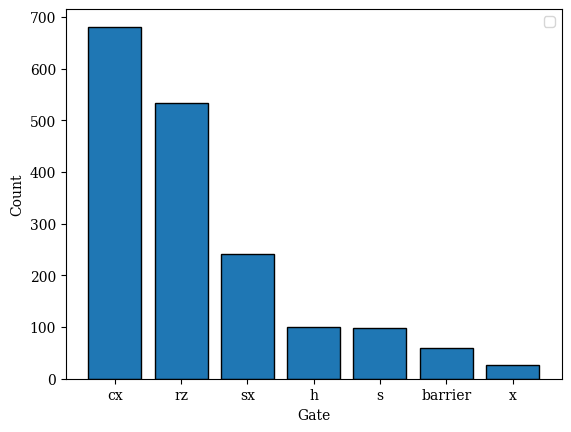

In [6]:
num = list(circuit.count_ops().values())
ops = list(circuit.count_ops().keys())
xs = np.array(range(len(ops)))

plt.bar(xs, num, edgecolor="black")
plt.xticks(xs, ops)
plt.xlabel("Gate")
plt.ylabel("Count")
plt.legend();
# plt.title("Ansatz 2");

## Run on hardware

In [7]:
from qiskit.transpiler.passes import RemoveBarriers

In [8]:
circuit = RemoveBarriers()(circuit)

In [9]:
to_run = qiskit.transpile(
    circuit,
    optimization_level=3,
    backend=computer,
    initial_layout=qubits,
)
to_run.measure_active()
to_run.count_ops()

OrderedDict([('sx', 1612),
             ('rz', 1100),
             ('cz', 856),
             ('x', 44),
             ('measure', 14),
             ('barrier', 1)])

In [10]:
to_run.draw(fold=-1)

global phase: 3π/2
          ┌────────────┐     ┌────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ┌────┐    ┌───────┐      ┌────┐ ┌────────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [11]:
# job = sampler.run([to_run], shots=nshots)
job = service.job("d499ugfnmdfs73ablva0")

In [12]:
all_counts_hardware = []

In [13]:
res = job.result()

In [14]:
for r in res:
    all_counts_hardware.append(r.data.meas.get_counts())

In [ ]:
import datetime


time_key = datetime.datetime.now().strftime("%Y_%m_%d_%H:%M:%S")
fname = circuit_fname + f"_counts_{computer.name}_nshots_{nshots}_{time_key}"
fname

In [ ]:
pickle.dump(all_counts_hardware[0], open(fname, "wb"))

## Run SQD

In [15]:
import collections
from functools import partial
import os

from qiskit.primitives import BitArray
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

In [16]:
file = os.path.expanduser(f'./hamiltonians/14q-jan13/h2o-integrals.npz')

integrals_data = np.load(file, allow_pickle=True)
integrals_data

NpzFile './hamiltonians/14q-jan13/h2o-integrals.npz' with keys: NELEC, NORB, ECORE, H1, H2

In [17]:
h1 = integrals_data['H1']
h2 = integrals_data['H2']
n_orbitals = integrals_data['NORB']
num_electrons = integrals_data['NELEC']
ecore = integrals_data['ECORE']

In [18]:
bitstrings_files = ["./results/kingston/h2o_circs_circuit_681_2q.qasm_counts_ibm_kingston_nshots_10000_2026_01_13_22:59:46"]

In [19]:
energy_tol = 1e-8
occupancies_tol = 1e-8
carryover_threshold = 1e-5

In [20]:
if bitstrings_files is not None:
    
    print(f'Loading bitstrings from file(s): {bitstrings_files}')
    bitstring_counts = collections.Counter()
    for fname in bitstrings_files:
        counts = pickle.load(open(fname, 'rb'))
        for bitstring, count in counts.items():
            bitstring_counts[bitstring] += count
    bitstring_counts = dict(bitstring_counts)

    measurement_outcomes = bitstring_counts
    permuted_outcomes = {}
    for original_bitstring in measurement_outcomes.keys():

        qubit_permuted_bitstring = "".join([original_bitstring[qubit_order.index(n)] for n in range(nqubits)])
        mode_permuted_bitstring = "".join([qubit_permuted_bitstring[mode_order.index(n)] for n in range(nqubits)])
        permuted_outcomes[mode_permuted_bitstring] = measurement_outcomes[original_bitstring]

    bit_array = BitArray.from_counts(permuted_outcomes)
    counts = bit_array.get_counts()
    max_key = max(counts, key=counts.get)
    print(f'Most common bitstring: {max_key} with count {counts[max_key]}')
    print(f'Total number of bitstrings: {len(counts)}')
    print(f"Total number of samples:", sum(bitstring_counts.values()))

Loading bitstrings from file(s): ['./results/kingston/h2o_circs_circuit_681_2q.qasm_counts_ibm_kingston_nshots_10000_2026_01_13_22:59:46']
Most common bitstring: 11001011001110 with count 7
Total number of bitstrings: 7172
Total number of samples: 10000


In [21]:
# SQD code.
sci_solver = partial(solve_sci_batch, spin_sq=0, max_cycle=10000)
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + ecore}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")

result = diagonalize_fermionic_hamiltonian(
    one_body_tensor=h1,
    two_body_tensor=h2,
    bit_array=bit_array,
    samples_per_batch=10,
    norb=n_orbitals,
    nelec=(num_electrons // 2, num_electrons // 2),
    num_batches=2,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=100,
    sci_solver=sci_solver,
    symmetrize_spin=True,
    carryover_threshold=carryover_threshold,
    callback=callback
    )

Iteration 1
	Subsample 0
		Energy: -74.42447945695501
		Subspace dimension: 100
	Subsample 1
		Energy: -74.86258700897787
		Subspace dimension: 169
Iteration 2
	Subsample 0
		Energy: -74.88446640071757
		Subspace dimension: 289
	Subsample 1
		Energy: -74.8898046574042
		Subspace dimension: 361
Iteration 3
	Subsample 0
		Energy: -74.8898046574042
		Subspace dimension: 361
	Subsample 1
		Energy: -74.8898046574042
		Subspace dimension: 361
